<a href="https://colab.research.google.com/github/nonoumasy/LA-Crime-Data-2010-2019/blob/master/LA_Crime_2010_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
# pandas as pd
import pandas as pd
import numpy as np
import re
#import wget
import folium
from pandas import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly as py
import seaborn as sns

%matplotlib inline

In [0]:
#download and load dataset from site(most updated dataset) - takes about 2m0s
url = 'https://data.lacity.org/api/views/63jg-8b9z/rows.csv?accessType=DOWNLOAD&api_foundry=true'


In [0]:
#clean and prepare the data - 51.6s

def clean_df(url):
    '''
    cleans the df
    '''
    #load data into chunks since its a BIG file and then concat it back
    df = pd.read_csv(url, chunksize=10000, iterator=True)
    df = pd.concat(df)
    
    #keep only relevant columns
    df = df[['DATE OCC','TIME OCC','AREA NAME','Crm Cd', 'Crm Cd Desc','Mocodes', 
             'Vict Age', 'Vict Sex','Vict Descent','Premis Desc','Weapon Desc',
             'Status Desc', 'LOCATION', 'Cross Street', 'LAT', 'LON']]
    
    #column cleanup
    df.columns = df.columns.str.lower().str.replace('\W+', '_').str.replace('(', '').str.replace(')', '')
    
    #change some columns to category type
    for col in df.select_dtypes(['object']):   
        df[col] = df[col].astype('category')
    
    #cleanup and process datatime data
    df.time_occ = df.time_occ.astype(str)
    df.time_occ = df.time_occ.str.zfill(4)
    df.time_occ = df.time_occ.str.ljust(6, fillchar='0')
    df.time_occ = df.time_occ.str.slice(0,2) + ':' + df.time_occ.str.slice(2,4) + ":" + df.time_occ.str.slice(4,6)
    
    #combine date and time and convert to datetime series
    df['date_occ'] = df['date_occ'].str.split(' ').str[0]
    df['date_time'] = df.date_occ + df.time_occ
    df.date_time = pd.to_datetime(df.date_time, format='%m/%d/%Y%H:%M:%S')
    
    #set date_time as index
    df.set_index('date_time', inplace=True)
    
    #cleans up whitespaces on address
    df.location = df.location.str.lstrip().str.rstrip().str.strip()
    df.location = (df['location'].str.split()).str.join(' ')
    
    #replace race names using map
    race_dict = {'A' : 'Other Asian',
            'B' : 'Black', 
            'C' : 'Chinese', 
            'D' : 'Cambodian', 
            'F' : 'Filipino', 
            'G' : 'Guamanian', 
            'H' : 'Hispanic/Latin',
            'I' : 'AmerIndian/Alaskan',
            'J' : 'Japanese', 
            'K' : 'Korean', 
            'L' : 'Laotian', 
            'O' : 'Other', 
            'P' : 'Pacific Islander ',
            'S' : 'Samoan', 
            'U' : 'Hawaiian',
            'V' : 'Vietnamese', 
            'W' : 'White', 
            'X' : 'Unknown', 
            'Z' : 'Asian Indian'}

    df['vict_descent'] = df['vict_descent'].map(race_dict)
    
    #find outliers and normalize
    for val in range(int(86.0),int(119.0)):
        df.vict_age.replace(val, np.nan, inplace=True)
    
    df.vict_age.replace(0.0, np.nan, inplace=True)
    
    #drop unnecessary columns
    df.drop(['date_occ', 'time_occ'], axis=1, inplace=True)
    
    return df

df = clean_df(url)

In [43]:
df.crm_cd_desc.nunique()

141

In [23]:
df.head()

,area_name,crm_cd,crm_cd_desc,mocodes,vict_age,vict_sex,vict_descent,premis_desc,weapon_desc,status_desc,location,cross_street,lat,lon
date_time,,,,,,,,,,,,,,
2010-02-20 13:50:00,Newton,900,VIOLATION OF COURT ORDER,0913 1814 2000,48.0,M,Hispanic/Latin,SINGLE FAMILY DWELLING,NaN,Adult Arrest,300 E GAGE AV,NaN,33.9825,-118.2695
2010-09-12 00:45:00,Pacific,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0329,NaN,M,White,STREET,NaN,Invest Cont,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962
2010-08-09 15:15:00,Newton,946,OTHER MISCELLANEOUS CRIME,0344,NaN,M,Hispanic/Latin,ALLEY,NaN,Invest Cont,1300 E 21ST ST,NaN,34.0224,-118.2524
2010-01-05 01:50:00,Hollywood,900,VIOLATION OF COURT ORDER,1100 0400 1402,47.0,F,White,STREET,HAND GUN,Invest Cont,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295
2010-01-02 21:00:00,Central,122,"RAPE, ATTEMPTED",0400,47.0,F,Hispanic/Latin,ALLEY,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,8TH ST,SAN PEDRO ST,34.0387,-118.2488


In [35]:
indexNames = df[ (df['vict_sex'] != 'M') & (df['vict_sex'] != 'F') ].index
new_df = df.drop(indexNames)
new_df.dropna(inplace=True)
new_df.vict_sex.unique()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[F, M]
Categories (2, object): [F, M]

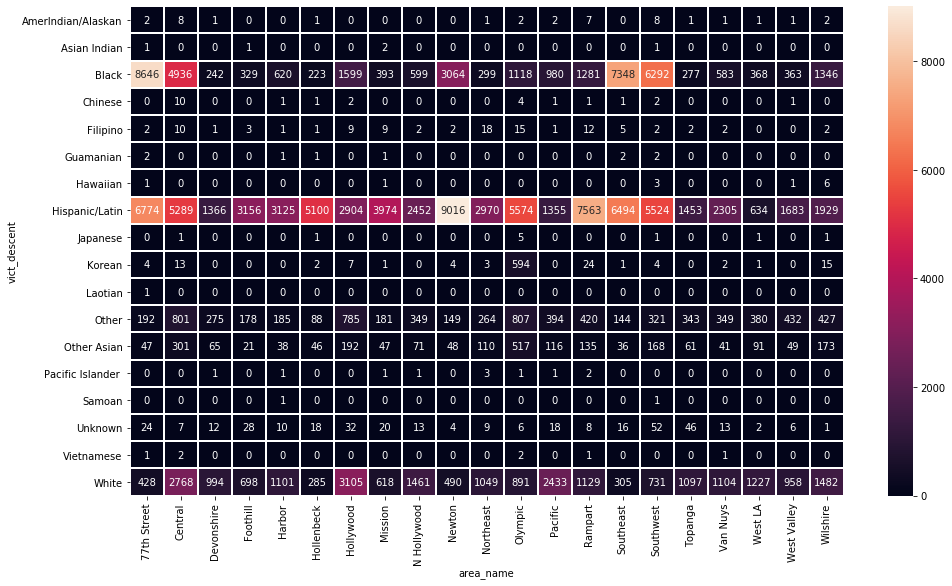

In [55]:
sex_race_tab = pd.crosstab(index = new_df.vict_descent, columns=new_df.area_name)
plt.figure(figsize=(16,9))
sns.heatmap(sex_race_tab,
            fmt="d",
            linewidths=1,
            annot=True)

In [0]:

from scipy.stats import chi2_contingency

In [47]:
x2, p_value, dof, array = chi2_contingency(sex_race_tab)
print('x2 = ', x2)
print('p_value: ', p_value)
print('dof: ', dof)

x2 =  1919.4323504612678
p_value:  0.0
dof:  20


In [0]:
#read crime level doc

#crime_code = '/Users/nonoumasy/Dropbox/reference/data/crime_level.py'
crime_code = 'drive/My Drive/Colab Notebooks/LA/LA crime/crime_level.py'

with open(crime_code) as f:
    crime_level = f.read()
print(crime_level)

#create a dictionary from crime level lists
d1 = dict.fromkeys(felony_list, 'felony')
d2 = dict.fromkeys(misdeamenors_list, 'misdeamenors')
d3 = dict.fromkeys(offenses_list, 'offenses')

crime_level_dict = {**d1, **d2, **d3}

#create crime level column from crime_level_dict
df['crime_level'] = df.crm_cd_desc.map(crime_level_dict)


felony_list = \
[
'VEHICLE - STOLEN', 
'INTIMATE PARTNER - SIMPLE ASSAULT', 
'PIMPING', 
'INTIMATE PARTNER - AGGRAVATED ASSAULT', 
'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
'BATTERY WITH SEXUAL CONTACT', 
'RAPE, FORCIBLE', 'ORAL COPULATION',
'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT', 
'ROBBERY',
'BATTERY - SIMPLE ASSAULT', 
'KIDNAPPING',
'CHILD NEGLECT (SEE 300 W.I.C.)',
'CRIMINAL THREATS - NO WEAPON DISPLAYED', 
'BRANDISH WEAPON',
'PURSE SNATCHING', 
'BURGLARY', 
'BURGLARY FROM VEHICLE, ATTEMPTED',
'OTHER ASSAULT',
'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH',
'BURGLARY FROM VEHICLE', 
'BURGLARY, ATTEMPTED', 
'TRESPASSING',
'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER', 
'CONSPIRACY',
'BATTERY POLICE (SIMPLE)', 
'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)',
'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT', 
'ATTEMPTED ROBBERY', 
'COUNTERFEIT',
'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)',
'ARSON',
'THEFT, PERSON', 
'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASS

NameError: ignored

# Exploratory Data Analysis (EDA)

In [0]:
df.describe()

,crm_cd,vict_age,lat,lon
count,2.028334e+06,1.667174e+06,2.028334e+06,2.028334e+06
mean,5.070086e+02,3.821345e+01,3.406333e+01,-1.183072e+02
std,2.105026e+02,1.563340e+01,7.234703e-01,2.482409e+00
min,1.100000e+02,-9.000000e+00,0.000000e+00,-1.188279e+02
25%,3.300000e+02,2.600000e+01,3.401020e+01,-1.184366e+02
50%,4.410000e+02,3.600000e+01,3.406240e+01,-1.183295e+02
75%,6.260000e+02,4.900000e+01,3.417580e+01,-1.182780e+02
max,9.560000e+02,8.500000e+01,3.479070e+01,0.000000e+00


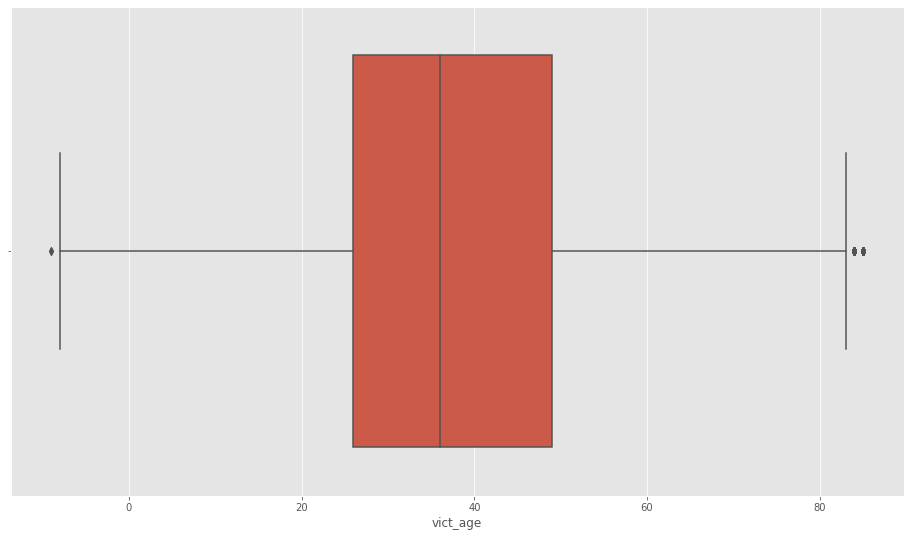

In [0]:
plt.figure(figsize=(16,9))
sns.boxplot(x=df.vict_age)

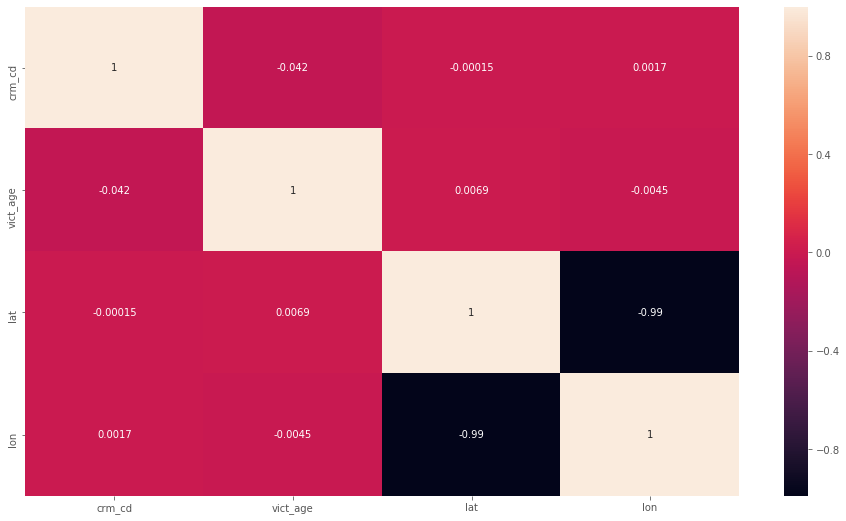

In [0]:
#correlation between the data
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(), annot=True)

In [0]:
#what type of crime is most prevalent?
df.crm_cd_desc.value_counts(dropna=True)[:5]

BATTERY - SIMPLE ASSAULT              174932
BURGLARY FROM VEHICLE                 148665
VEHICLE - STOLEN                      147517
BURGLARY                              137460
THEFT PLAIN - PETTY ($950 & UNDER)    137145
Name: crime_code_description, dtype: int64

In [0]:
#what type of crime is least prevalent?
df.crm_cd_desc.value_counts()[-5:]

BLOCKING DOOR INDUCTION CENTER              3
TILL TAP - ATTEMPT                          3
FIREARMS RESTRAINING ORDER (FIREARMS RO)    2
TRAIN WRECKING                              2
DRUNK ROLL - ATTEMPT                        1
Name: crime_code_description, dtype: int64

In [0]:
#where was there most crime?
df.area_name.value_counts().[:5]

77th Street    131722
Southwest      122674
N Hollywood    103320
Pacific        100906
Southeast      100288
Name: area_name, dtype: int64

In [0]:
#where was there least crime?
df.area_name.value_counts()[-5:]

Rampart       80521
West LA       80127
Wilshire      78481
Foothill      72360
Hollenbeck    70000
Name: area_name, dtype: int64

In [0]:
#Where did most murders occured?
df[df.crm_cd_desc == 'CRIMINAL HOMICIDE'].area_name.value_counts()[:5]

Pacific      0
Northeast    0
Newton       0
Hollywood    0
Central      0
Name: area_name, dtype: int64

In [0]:
#Where did most Rapes occured?
df[df.crm_cd_desc == 'RAPE, FORCIBLE'].area_name.value_counts()

77th Street    726
Hollywood      661
Southwest      617
Southeast      571
Central        569
Rampart        497
Mission        434
N Hollywood    434
Pacific        428
Olympic        407
Foothill       379
Topanga        359
Van Nuys       358
Harbor         346
Hollenbeck     345
West Valley    344
Newton         339
Northeast      332
Wilshire       327
West LA        319
Devonshire     319
Name: area_name, dtype: int64

In [0]:
#Where did most robbery occured?
df[df.crm_cd_desc == 'ROBBERY'].area_name.value_counts()

77th Street    9303
Southeast      7338
Southwest      6725
Newton         6328
Rampart        5076
Olympic        4800
Central        4524
Hollywood      3840
Wilshire       2853
Mission        2843
Hollenbeck     2576
Northeast      2499
Harbor         2334
Pacific        2304
N Hollywood    2176
Van Nuys       1912
West Valley    1882
Topanga        1878
Foothill       1829
Devonshire     1603
West LA        1437
Name: area_name, dtype: int64

In [0]:
#Crime by year
print('Crime by year')
print(df.index.year.value_counts())
print()

Crime by year
2010    100
Name: date_time, dtype: int64



In [50]:
#Crime by day of week
print('Crime by day of week')
print(df.index.dayofweek.value_counts().sort_index())
print()

Crime by day of week
0    300971
1    295200
2    298417
3    296966
4    324383
5    303736
6    290545
Name: date_time, dtype: int64



In [0]:
#Crime by day of hour
print('Crime by hour')
print(df.index.hour.value_counts()[:5])
print()

Crime by hour
20    11
0      9
1      9
2      7
15     7
Name: date_time, dtype: int64



In [0]:
# Top 5 crimes against women
print('Main Crime type against women')
print(df[df['vict_sex'] == 'F' ].crm_cd_desc.value_counts()[:5])
print()

Main Crime type against women
BATTERY - SIMPLE ASSAULT                          11
INTIMATE PARTNER - SIMPLE ASSAULT                  7
VANDALISM - MISDEAMEANOR ($399 OR UNDER)           3
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT     2
BURGLARY FROM VEHICLE                              2
Name: crm_cd_desc, dtype: int64



In [0]:
# Top 5 crimes against men
print('Main Crime type against men')
print(df[df['vict_sex'] == 'M' ].crm_cd_desc.value_counts()[:5])
print()

Main Crime type against women
BATTERY - SIMPLE ASSAULT              64170
BURGLARY FROM VEHICLE                 62490
BURGLARY                              62083
THEFT PLAIN - PETTY ($950 & UNDER)    58009
THEFT OF IDENTITY                     46877
Name: crime_code_description, dtype: int64



In [0]:
# Murder Victims by gender
df[df['crm_cd_desc'] == 'CRIMINAL HOMICIDE' ].vict_sex.value_counts()[:5]

M    1774
F     280
X       1
Name: victim_sex, dtype: int64

In [0]:
# Murder Victims by gender
df[df['crm_cd_desc'] == 'CRIMINAL HOMICIDE' ].victim_descent.value_counts()[:5]

H    990
B    804
W    179
O     52
A     23
Name: victim_descent, dtype: int64

In [0]:
df[df['crm_cd_desc'] == 'CRIMINAL HOMICIDE' ].victim_age.value_counts().head()

20.0    88
19.0    81
23.0    77
26.0    73
25.0    73
Name: victim_age, dtype: int64

In [0]:
# Murder Victims by age
df[df['crm_cd_desc'] == 'CRIMINAL HOMICIDE' ].premis_desc.value_counts()[:5]

STREET                                          878
SIDEWALK                                        573
SINGLE FAMILY DWELLING                          259
MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)    251
PARKING LOT                                     154
Name: premis_desc, dtype: int64

In [0]:
#pivot table
df.pivot_table(index='victim_descent',
               columns='vict_sex',
               values='victim_age',
               aggfunc='sum',
              fill_value=0)

victim_sex,-,F,H,M,N,X
victim_descent,,,,,,
AmerIndian/Alaskan,0,6266,0,13767,0,0
Asian Indian,0,676,0,1082,0,0
Black,0,5077478,88,3895812,0,45
Cambodian,0,160,0,266,0,0
Chinese,0,10477,0,10679,0,0
Filipino,47,38395,215,33855,0,23
Guamanian,0,1229,0,578,0,0
Hawaiian,0,1920,0,1889,0,0
Hispanic/Latin,0,8631289,801,8534050,61,192


In [0]:
# Murder Victims by gender
df[df['crm_cd_desc'] == 'RAPE, FORCIBLE' ].area_name.value_counts()[:5]

77th Street    777
Hollywood      704
Southwest      665
Central        627
Southeast      609
Name: area_name, dtype: int64

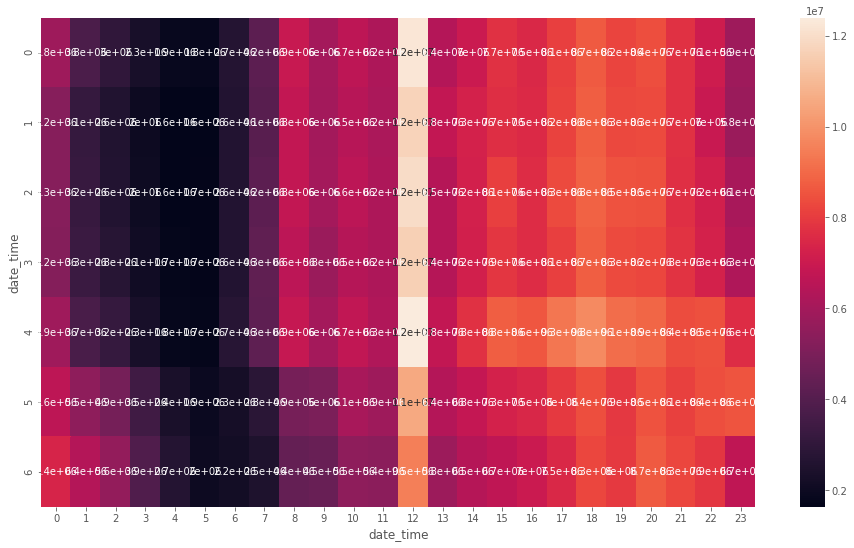

In [0]:
#plot of serious crimes -  hour vs. day_of_week
data = df.groupby([df.index.dayofweek, df.index.hour]).crm_cd.sum().unstack()
plt.figure(figsize=(16,9))         # Sample figsize in inches
sns.heatmap(data, annot=True)

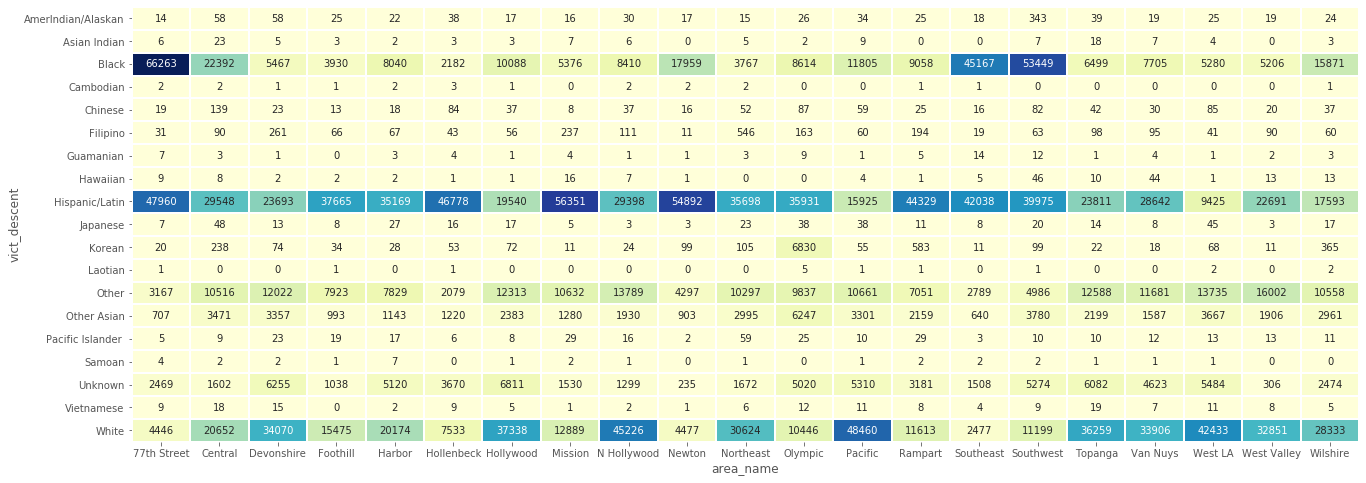

In [0]:
cross_tab = pd.crosstab(df.vict_descent, df.area_name)
fig, ax = plt.subplots(figsize=(22,8))         # Sample figsize in inches
sns.heatmap(cross_tab,
            cmap="YlGnBu",
            annot=True,
            fmt="d",
            linewidths=1,
            cbar=False,
            ax=ax)

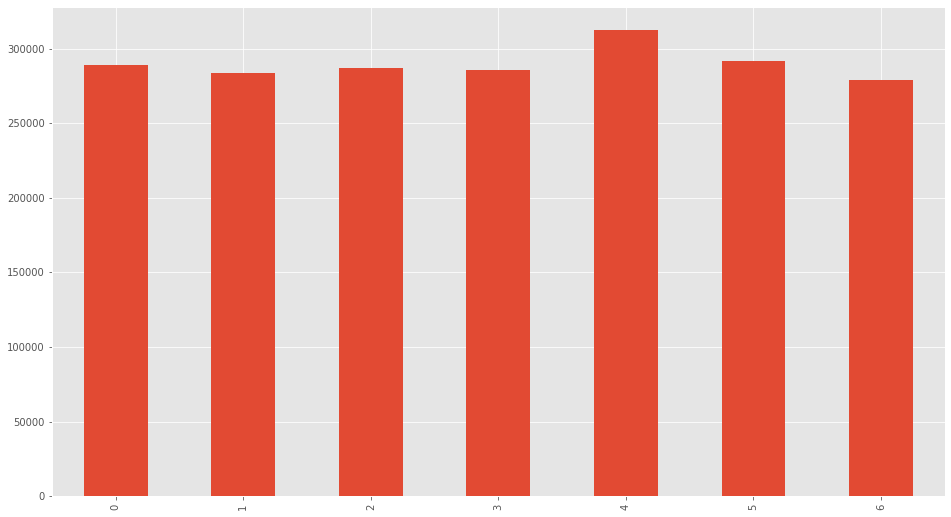

In [0]:
#When did most crimes occured in terms of days of the week?
plt.figure(figsize=(16,9))
df.index.dayofweek.value_counts().sort_index().plot(kind='bar')

In [0]:
#victims by gender
print(df.vict_sex.value_counts())
print()

#victims by race
print(df.vict_descent.value_counts())
print()

#victims by age
print('victims by avg age')
df.vict_age= df.vict_age.abs()
print(df.vict_age.mean())
print()


M    936172
F    854338
X     48801
H        67
N        17
-         1
Name: vict_sex, dtype: int64

Hispanic/Latin        697052
White                 490881
Black                 322528
Other                 194752
Unknown                70963
Other Asian            48829
Korean                  8820
Filipino                2402
Chinese                  929
AmerIndian/Alaskan       882
Japanese                 372
Pacific Islander         329
Hawaiian                 186
Vietnamese               162
Asian Indian             113
Guamanian                 80
Samoan                    31
Cambodian                 21
Laotian                   15
Name: vict_descent, dtype: int64

victims by avg age
38.214738833499084



In [0]:
#victims by gender and crime
print('Main crime incidents on Women')
print(df[df['vict_sex'] == 'F'].crm_cd_desc.value_counts()[:5])
print()
print('Main crime incidents on Men')
print(df[df['vict_sex'] == 'M'].crm_cd_desc.value_counts()[:5])
print()



Main crime incidents on Women
BATTERY - SIMPLE ASSAULT              95496
INTIMATE PARTNER - SIMPLE ASSAULT     87827
BURGLARY FROM VEHICLE                 69452
THEFT PLAIN - PETTY ($950 & UNDER)    63662
THEFT OF IDENTITY                     61475
Name: crm_cd_desc, dtype: int64

Main crime incidents on Men
BATTERY - SIMPLE ASSAULT                          87784
BURGLARY FROM VEHICLE                             85746
BURGLARY                                          80433
THEFT PLAIN - PETTY ($950 & UNDER)                75203
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT    64175
Name: crm_cd_desc, dtype: int64



Main crime incidents on Korean women between 20 and 30 years old in 2018


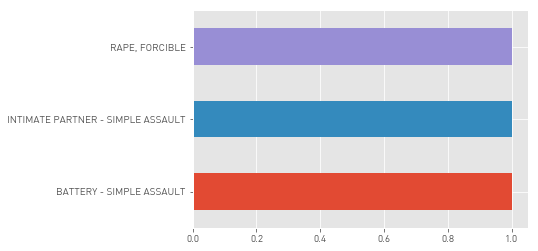

In [0]:
print('Main crime incidents on Korean women between 20 and 30 years old in 2018')
df[(df['victim_age'] >= 20)   
 & (df['victim_age'] <= 30) 
 & (df['vict_sex'] == 'F')
 & (df['victim_descent'] == 'Korean')
 & (df['year'] == 2018)].crm_cd_desc.value_counts().plot(kind='barh')


Main crime incidents on Japanese women between 20 and 40 years old in 2018


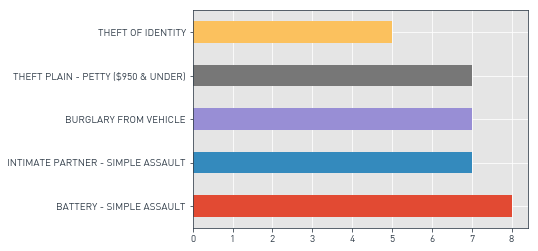

In [0]:
print('Main crime incidents on Japanese women between 20 and 40 years old in 2018')
df[(df['victim_age'] > 20)   
 & (df['victim_age'] < 40) 
 & (df['vict_sex'] == 'F')
 & (df['victim_descent'] == 'Japanese')].crm_cd_desc.value_counts()[:5].plot(kind='barh')


In [0]:
print('Main crime incidents on White women between 20 and 40 years old in 2018')
df[(df['victim_age'] > 20)   
 & (df['victim_age'] < 40) 
 & (df['vict_sex'] == 'F')
 & (df['victim_descent'] == 'White')].crm_cd_desc.value_counts()[:5]


Main crime incidents on White women between 20 and 40 years old in 2018


Rape incidents on White women between 20 and 40 years old in 2018


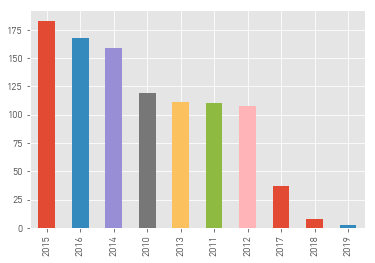

In [0]:
print('Rape incidents on White women between 20 and 40 years old in 2018')
df[(df['victim_age'] > 20)   
 & (df['victim_age'] < 40) 
 & (df['vict_sex'] == 'F')
 & (df['victim_descent'] == 'White')
 & (df['crm_cd_desc'] == 'RAPE, FORCIBLE')].year.value_counts().plot(kind='bar')

Main crime incidents on Black women between 20 and 40 years old in 2018


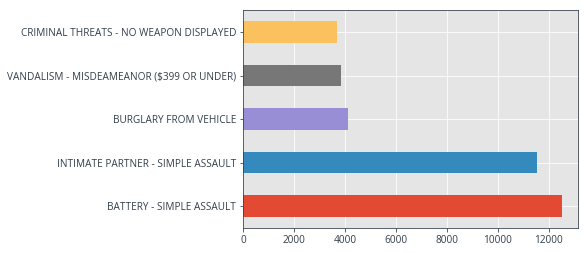

In [0]:
print('Main crime incidents on Black women between 20 and 40 years old in 2018')
df[(df['victim_age'] > 20)   
 & (df['victim_age'] < 40) 
 & (df['vict_sex'] == 'F')
 & (df['victim_descent'] == 'Black')].crm_cd_desc.value_counts()[:5].plot(kind='barh')


In [0]:
print('Main crime incidents on victims over 60 years old')
df[(df['victim_age'] < 60)].crm_cd_desc.value_counts()[:5]


Main crime incidents on victims over 60 years old


BATTERY - SIMPLE ASSAULT              127241
BURGLARY FROM VEHICLE                 105697
THEFT PLAIN - PETTY ($950 & UNDER)     92740
BURGLARY                               86491
INTIMATE PARTNER - SIMPLE ASSAULT      78932
Name: crime_code_description, dtype: int64

In [0]:
#Is crime increasing or decreasing in time?
df.datetime_series.dt.year.value_counts().sort_index()[0:9]

2010    208753
2011    200384
2012    201094
2013    192128
2014    194903
2015    214686
2016    224445
2017    229531
2018    224745
Name: datetime_series, dtype: int64

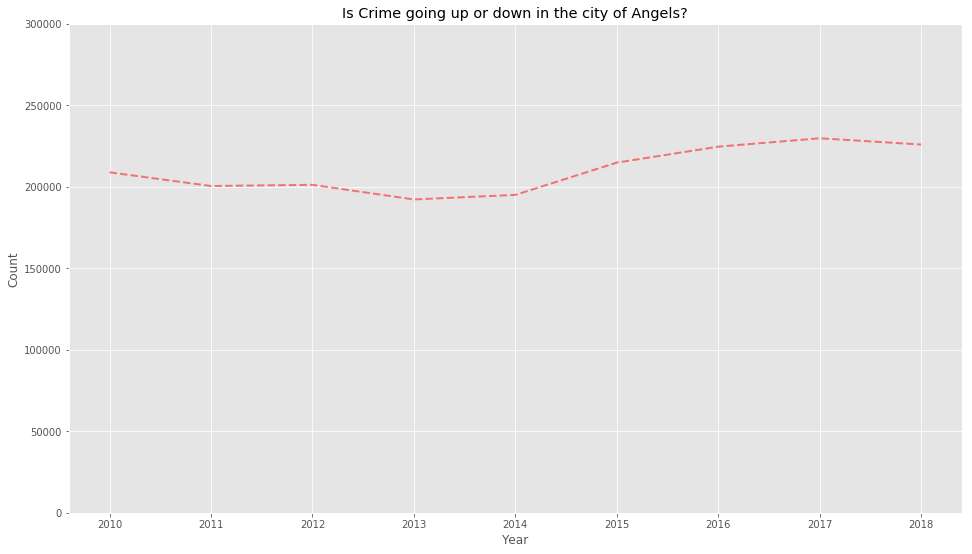

In [0]:
#Is crime increasing or decreasing in time? Show
trend = df.date_time.dt.year.value_counts().sort_index()[0:9]
plt.figure(figsize=(16,9))
plt.plot(trend, alpha=0.5, color='r' , linewidth=2, linestyle='--' )
plt.ylim(0,300000)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Is Crime going up or down in the city of Angels?')
plt.show()

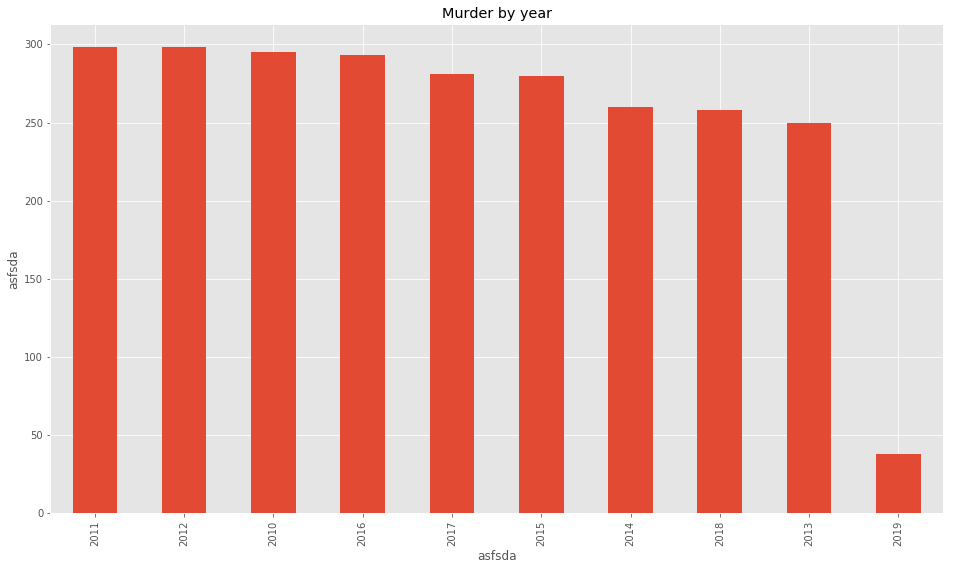

In [0]:
#murder by year
df[df['crm_cd_desc'] == 'CRIMINAL HOMICIDE' ].year.value_counts().plot(figsize=(16,9), kind='bar')
plt.xlabel('asfsda')
plt.ylabel('asfsda')
plt.title('Murder by year')
plt.show()


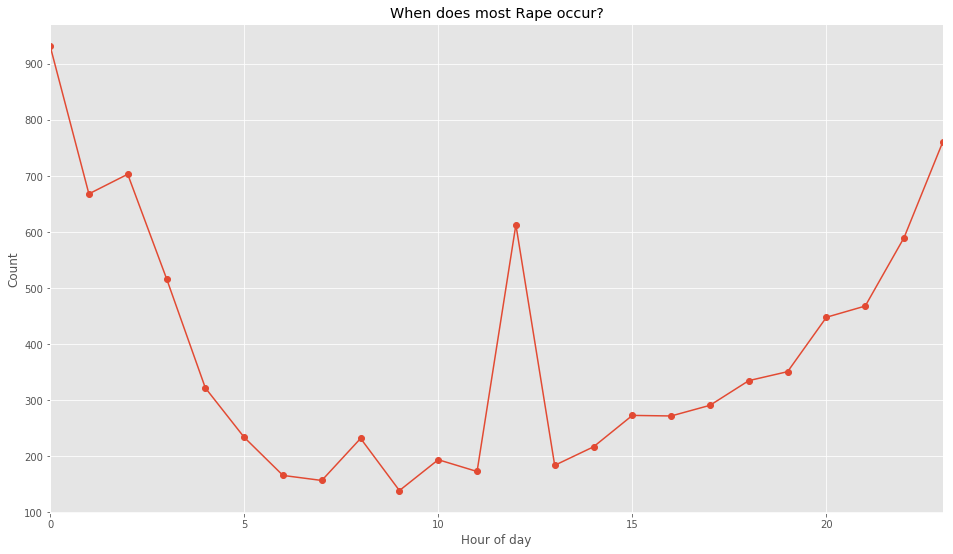

In [0]:
# When does most Rape occur?
df[df['crm_cd_desc'] == 'RAPE, FORCIBLE' ].date_time.dt.hour.value_counts().sort_index().plot(figsize=(16,9), marker='o')
plt.xlabel('Hour of day')
plt.ylabel('Count')
plt.title('When does most Rape occur?')
plt.show()

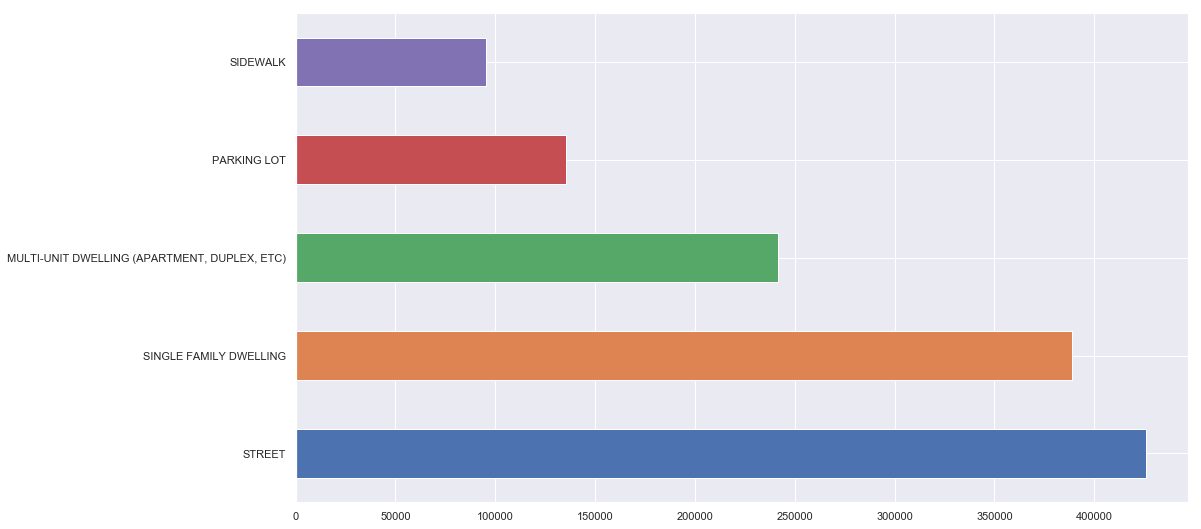

In [0]:
#where did crime incidents occur?
df.premise_description.value_counts()[:5].plot(kind='barh', figsize=(16,9))

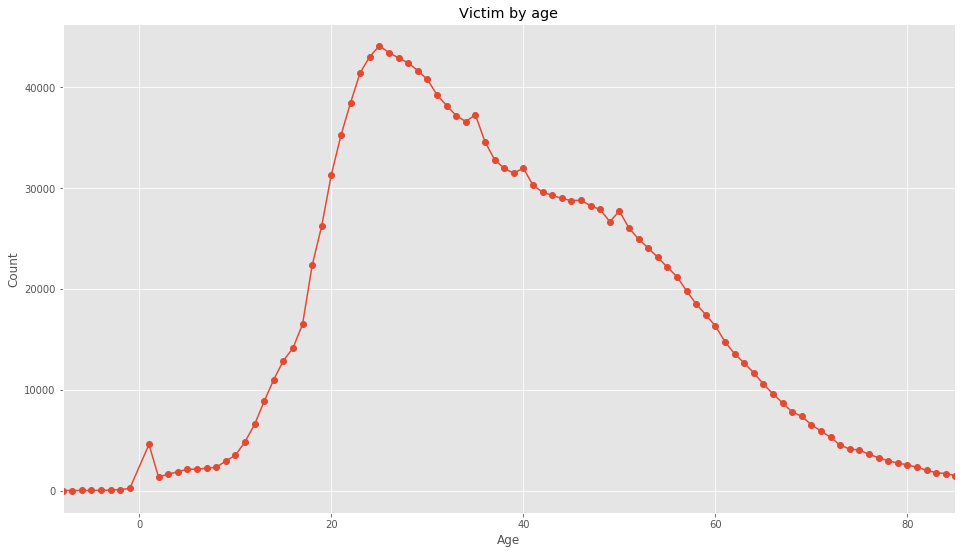

In [0]:
#Victim by age
df.victim_age.value_counts().sort_index().plot(figsize=(16,9),marker='o')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Victim by age')
plt.show()

# Time Series Analysis

In [0]:
#add some columns to df
df['year'] = df.index.year
df['count'] = 1

In [0]:
plot = px.histogram(df,
                    x='area_name',
                    color='area_name',
                    animation_frame='year',
                    title='LA Crime 2010-2019',
                    template='plotly_dark',
                   )

plot.layout.showlegend = False
py.offline.plot(plot, filename='/Users/nonoumasy/Desktop/la_crime.html')

speak("Now I'm really done!")

# Map

In [0]:
#map of crime in LA

from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap

m = folium.Map(
    location=[34.127141, -118.29008],
    zoom_start=13,
    tiles='StamenToner'
)

folium.plugins.Fullscreen(position='bottomright').add_to(m)

loc_list = northeast2019_df[['lat', 'lon']].values.tolist()
FastMarkerCluster(loc_list).add_to(m)

HeatMap(loc_list,
       ).add_to(m)

m.save('map.html')
m



# References:
*LAPD Crime 
    http://www.lapdonline.org/inside_the_lapd/content_basic_view/27333
    
*Crime Classification Grouping:
    https://www.nap.edu/read/23492/chapter/7#128